In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_np = props_to_np(props_as_ds)
props_as_ds_anoms = compute_prop_anomalies(props_as_ds)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
props_as_ds_normalized = props_as_ds.copy()
normalize = lambda da: (da - da.mean(axis=0)) / da.std(axis=0)
for varname in props_as_ds_normalized.data_vars:
    props_as_ds_normalized[varname] = normalize(props_as_ds_normalized[varname])
props_as_ds_yearly = props_as_ds.resample(time='1Y').mean()
props_as_ds_normd_yearly = props_as_ds_normalized.resample(time='1Y').mean()
overlaps, vert_dists = compute_all_overlaps(all_jets, props_as_ds_uncat)
overlaps_yearly = normalize(overlaps).resample(time='1Y').mean()
vert_dists_yearly = normalize(vert_dists).resample(time='1Y').mean()
props_as_ds_yearly['overlaps'] = overlaps_yearly
props_as_ds_yearly['vert_dists'] = vert_dists_yearly
da_overlaps, da_vert_dists = overlaps_vert_dists_as_da(
    da_s, all_jets, props_as_ds_uncat, exp_s.path
)
ds_pvs, ds_pvs_anoms = open_pvs(da_s)

## Better is_polar (WIP)

In [ ]:
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
def to_zero_one(x):
    return (x - x.min()) / (x.max() - x.min())
props_as_ds_uncat['int_ratio'] = props_as_ds_uncat['int_low'] / props_as_ds_uncat['int']
Lat = props_as_ds_uncat['mean_lat'].values
mask = ~np.isnan(Lat)
Lat = Lat[mask]
feature_names = ['mean_lon', 'mean_lat', 'int_ratio', 'Spe']
X = []
indices = np.random.randint(0, len(Lat), size=10000)
for feature_name in feature_names:
    X.append(to_zero_one(props_as_ds_uncat[feature_name].values[mask]))
X = np.asarray(X).T
# kmeans = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X)
kmeans = GaussianMixture(2).fit(X[indices])

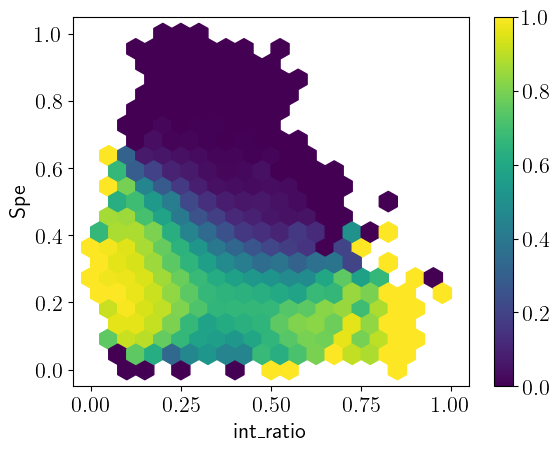

In [ ]:
from scipy.interpolate import griddata
fig, ax = plt.subplots()
# labels = kmeans.labels_
labels = kmeans.predict(X)
feature_ind = [2, 3]
im = ax.hexbin(*X[:, feature_ind].T, gridsize=20, C=labels)
ax.set_xlabel(feature_names[feature_ind[0]])
ax.set_ylabel(feature_names[feature_ind[1]])
fig.colorbar(im)
# offsets = im.get_offsets()
# sizes = im.get_sizes()
# counts = im.get_array()
# which = counts > 0.6 * counts.max()
# x, y = offsets.T
# xi = np.unique(x)
# yi = np.unique(y)
# x_, y_ = np.meshgrid(xi, yi)
# z = griddata(offsets, kmeans.labels_, (x_, y_))
# ax.contour(x_, y_, z, cmap='inferno')

## Trends

In [ ]:
from numpy.polynomial import Polynomial

def p_to_tex(p: Polynomial) -> str:
    coef1 = num2tex(p.coef[1])
    coef0 = num2tex(p.coef[0])
    sign = '+' if np.sign(p.coef[0]) else '-'
    string = f'$y={coef1}\cdot x {sign} {coef0}$'
    return string

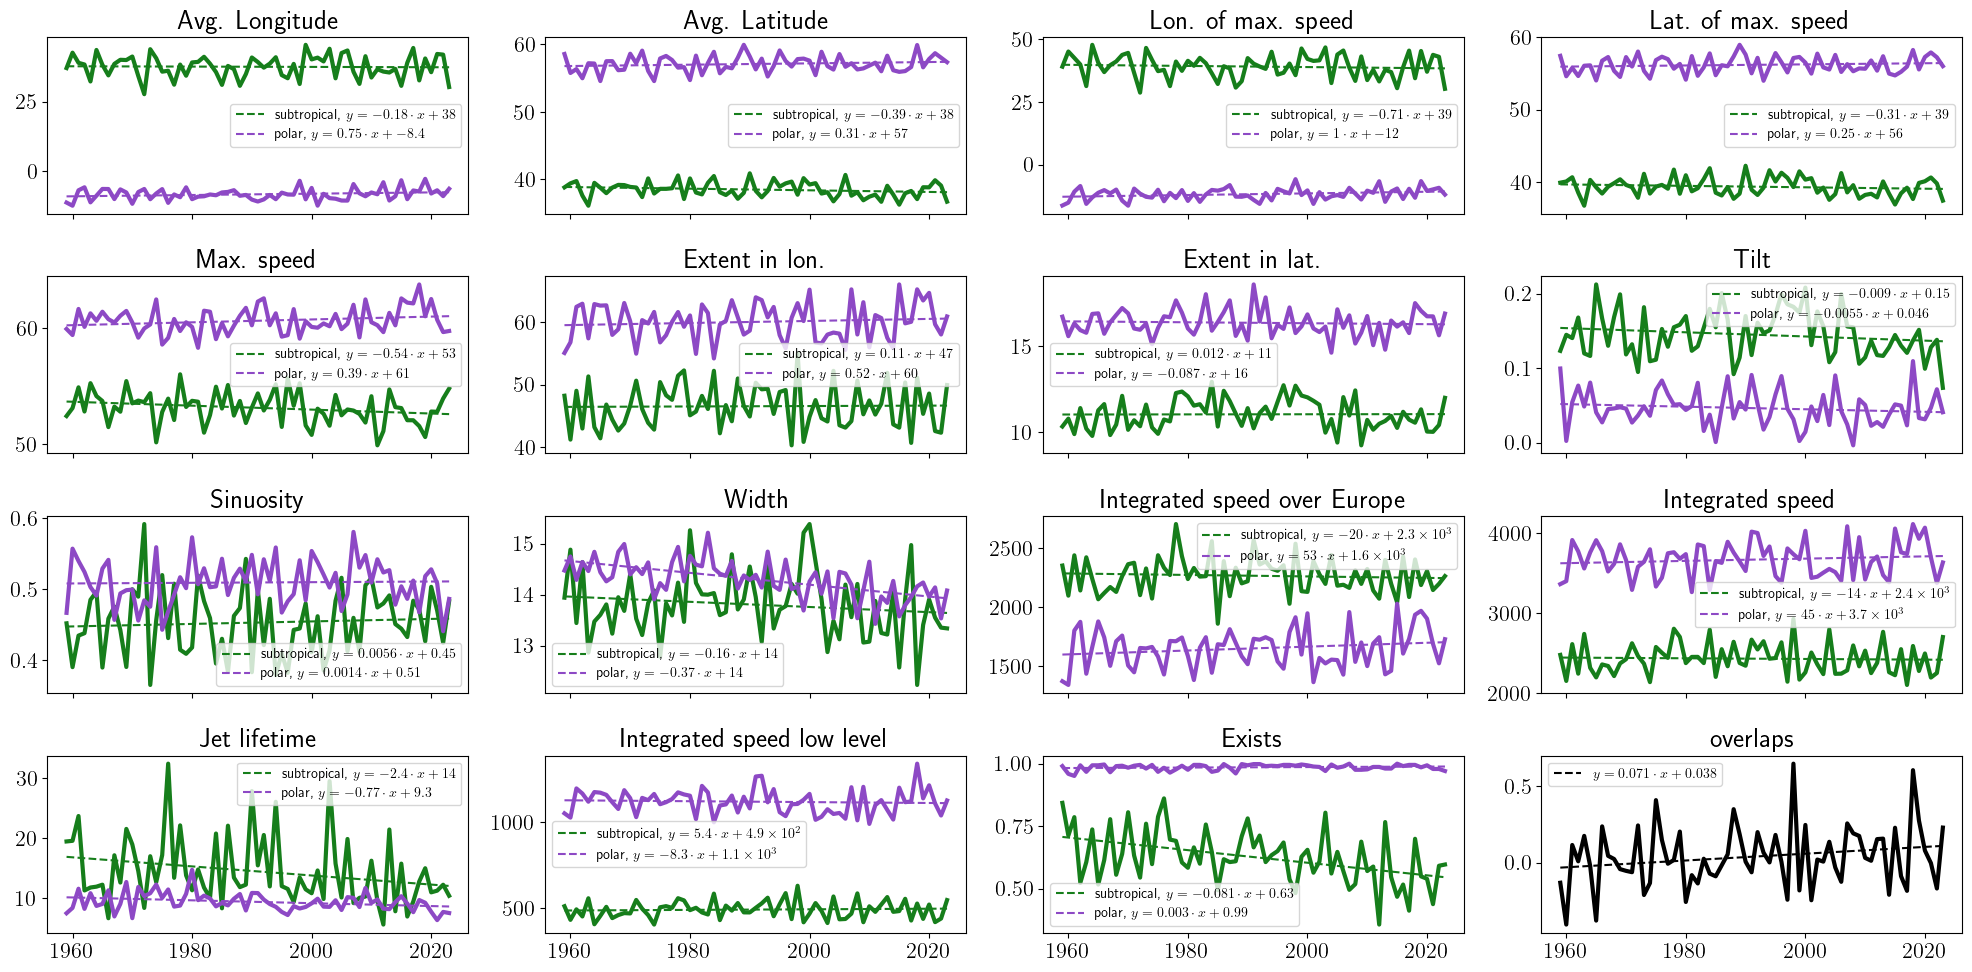

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), tight_layout=True, sharex='all')
axes = axes.flatten()
time_mask = (props_as_ds_yearly.time.dt.year >= 1959).values
x = props_as_ds_yearly.time[time_mask].dt.year.values
for i, (varname, ax) in enumerate(zip(props_as_ds_yearly.data_vars, axes)):
    for j, jet in enumerate(['subtropical', 'polar']):
        try:
            ax.set_title(PRETTIER_VARNAME[varname])
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color=COLORS5[j], ls='dashed', label=f'{jet}, {p_to_tex(p)}')
        except KeyError:
            this_da = props_as_ds_yearly[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color='black')
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color='black', ls='dashed', label=f'{p_to_tex(p)}')
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f'{FIGURES}/jet_props_misc/jet_props_trend_post_1959.png')

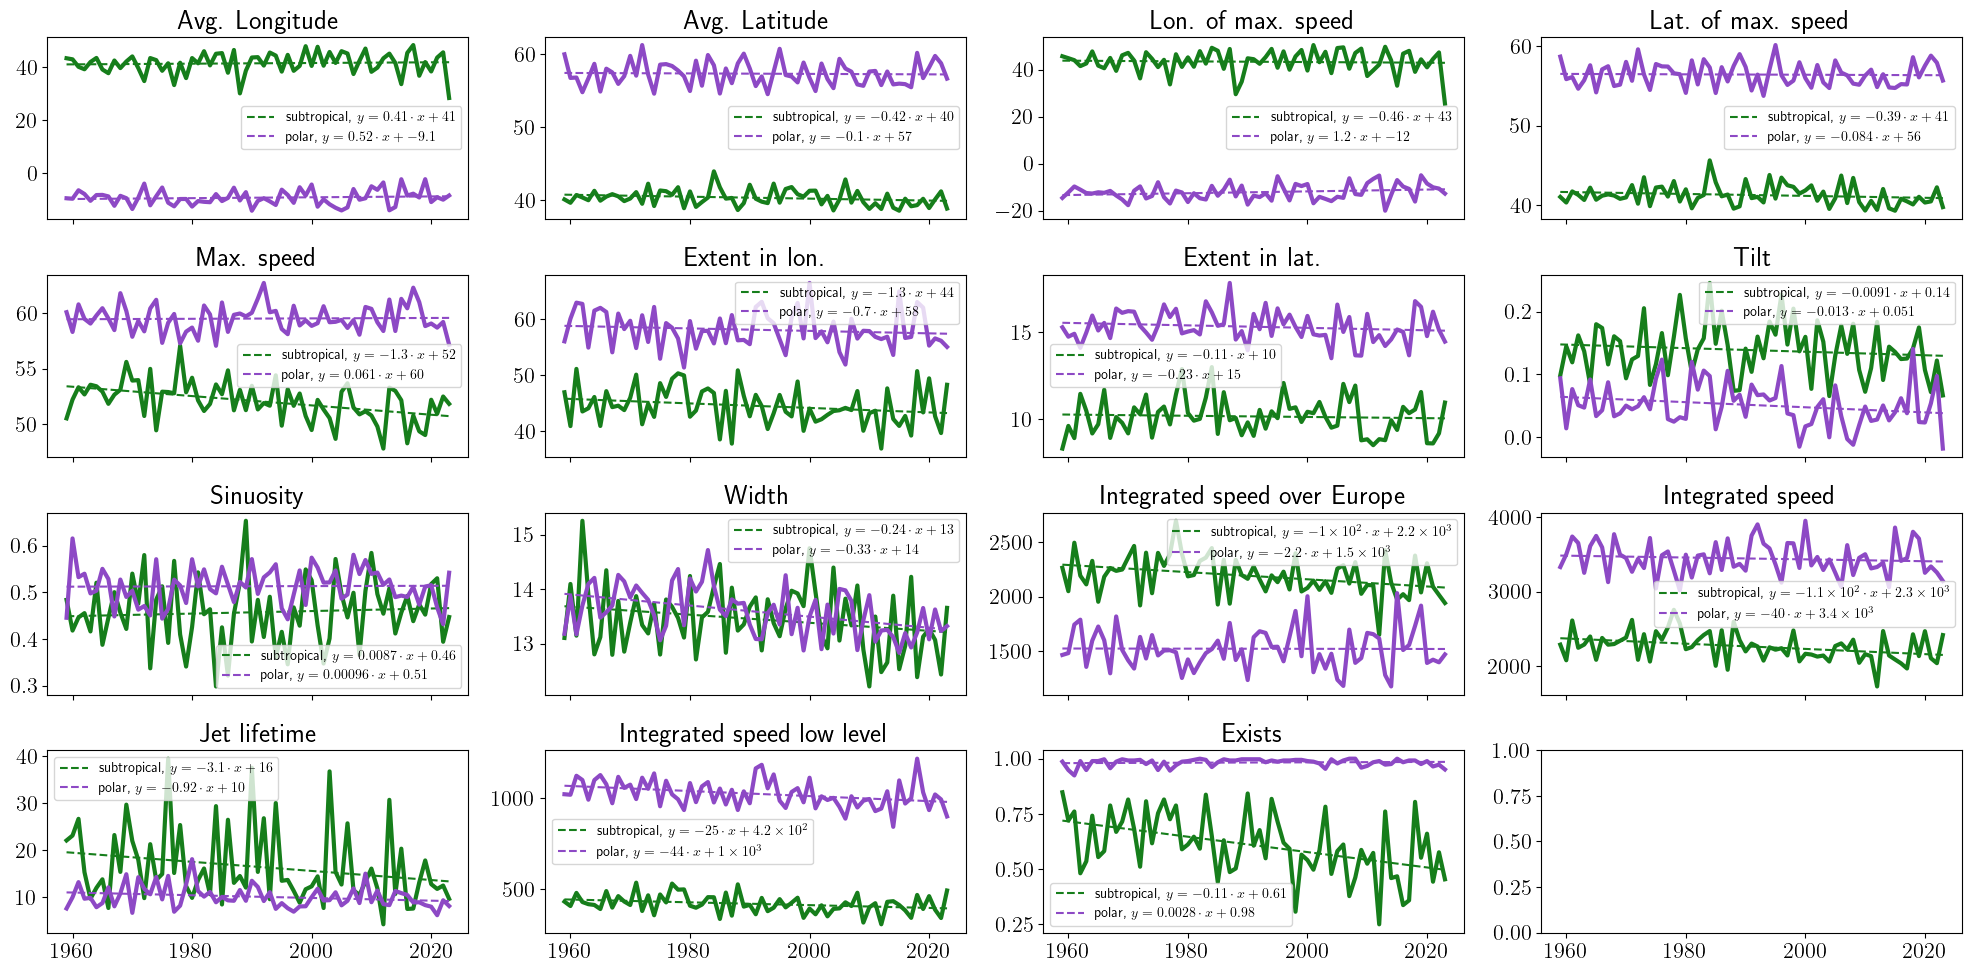

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10), tight_layout=True, sharex='all')
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = props_as_ds.sel(time=high_summer_mask).resample(time='1Y').mean()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
for i, (varname, ax) in enumerate(zip(props_as_ds_yearly_hs.data_vars, axes)):
    for j, jet in enumerate(['subtropical', 'polar']):
        try:
            ax.set_title(PRETTIER_VARNAME[varname])
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color=COLORS5[j], ls='dashed', label=f'{jet}, {p_to_tex(p)}')
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color='black')
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color='black', ls='dashed', label=f'{p_to_tex(p)}')
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f'{FIGURES}/jet_props_misc/jet_props_trend_post_1959.png')

## Correlations

In [ ]:
props_as_ds_late = props_as_ds.sel(time=props_as_ds.time.dt.year >= 1959)
props_as_ds_late['anti_pv_activity'] = ('time', ds_pvs['anti'].sum(dim=['lon', 'lat']).values)
props_as_ds_late['cycl_pv_activity'] = ('time', ds_pvs['cycl'].sum(dim=['lon', 'lat']).values)
props_as_ds_late['overlaps'] = overlaps.sel(time=overlaps.time.dt.year >= 1959)
props_as_ds_late['n_jets'] = (~props_as_ds_uncat['mean_lat'].isnull()).sum(dim='jet')

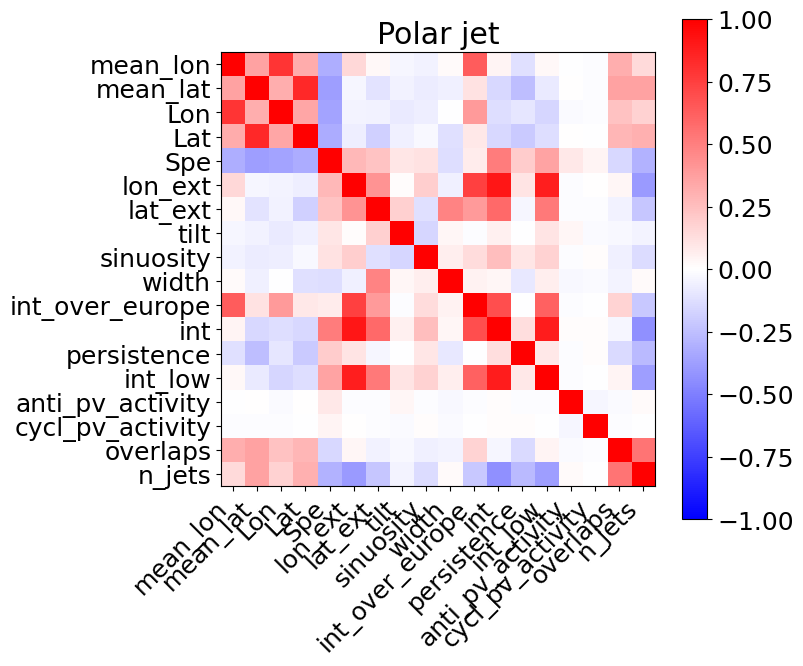

In [ ]:
to_concat = []
polar_valids = ~props_as_ds_late['mean_lon'].sel(jet='polar').isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in ['anti_pv_activity', 'cycl_pv_activity', 'overlaps', 'vert_dists', 'n_jets']:
        to_concat.append(da.sel(jet='polar').values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars, rotation=45, ha='right')
ax.set_title('Polar jet')
fig.savefig(f'{FIGURES}/jet_props_misc/jet_props_corr_polar.png')

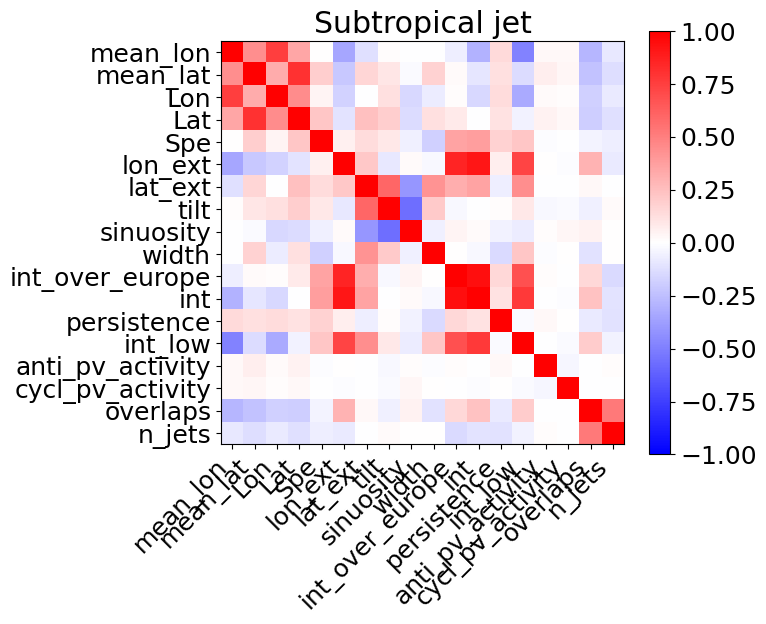

In [ ]:
to_concat = []
subtrop_valids = ~props_as_ds_late['mean_lon'].sel(jet='subtropical').isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in ['anti_pv_activity', 'cycl_pv_activity', 'overlaps', 'vert_dists', 'n_jets']:
        to_concat.append(da.sel(jet='subtropical').values[subtrop_valids])
    else:
        to_concat.append(np.roll(da.fillna(0).values[subtrop_valids], 0))
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars, rotation=45, ha='right')
ax.set_title('Subtropical jet')
fig.savefig(f'{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png')

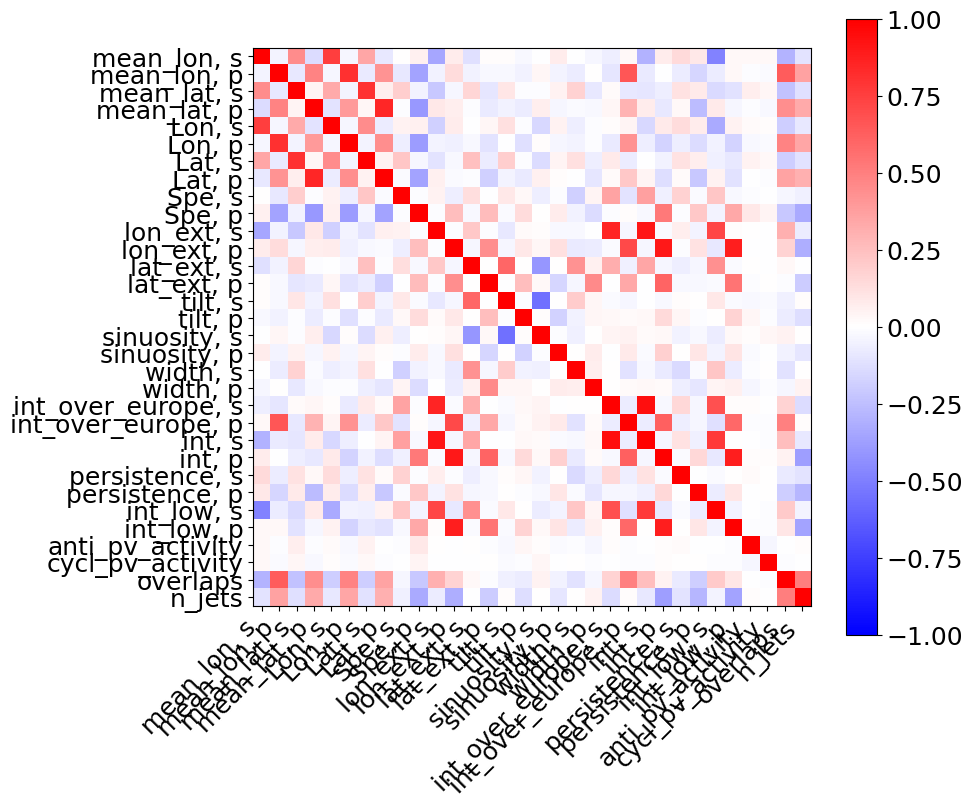

In [ ]:
to_concat = []
ticks = []
valids = props_as_ds_late['mean_lon']
valids = (~valids.sel(jet='polar').isnull() & ~valids.sel(jet='subtropical').isnull()).values
for varname, da in props_as_ds_late.items():
    if varname not in ['anti_pv_activity', 'cycl_pv_activity', 'overlaps', 'vert_dists', 'n_jets']:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).values[valids])
            ticks.append(f'{varname}, {jet[0]}')
    else:
        to_concat.append(np.roll(da.values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(9, 8))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(ticks)), ticks)
_ = ax.set_xticks(np.arange(0, len(ticks)), ticks, rotation=45, ha='right')
fig.savefig(f'{FIGURES}/jet_props_misc/jet_props_corr_full.png')

## Overlaps vs absolute lon / lat

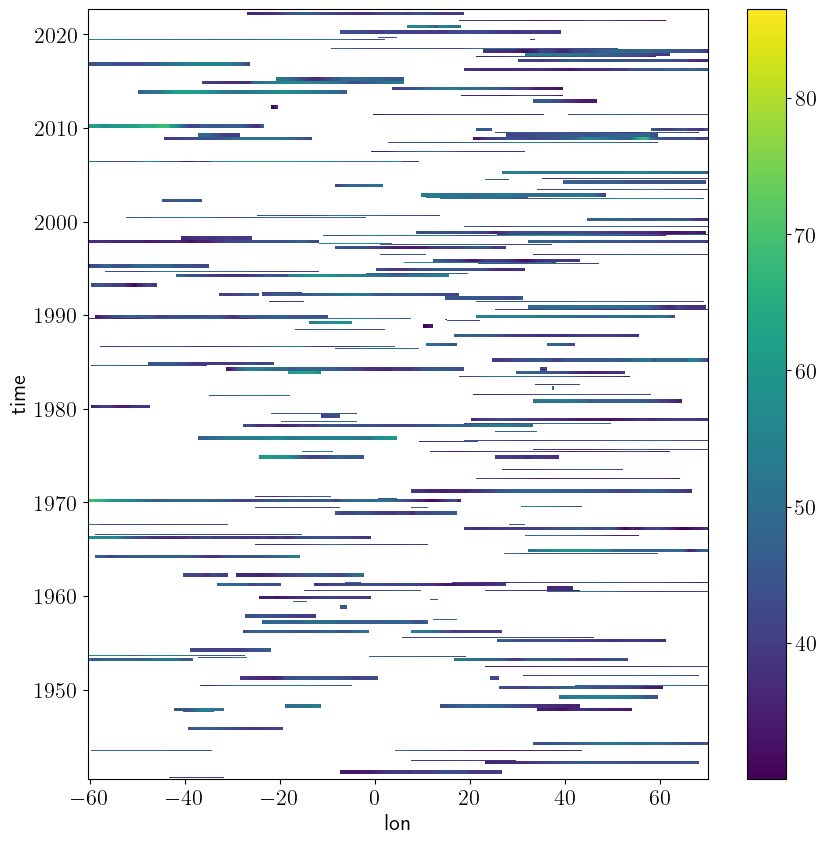

In [ ]:
da_overlaps.plot(figsize=(10, 10))

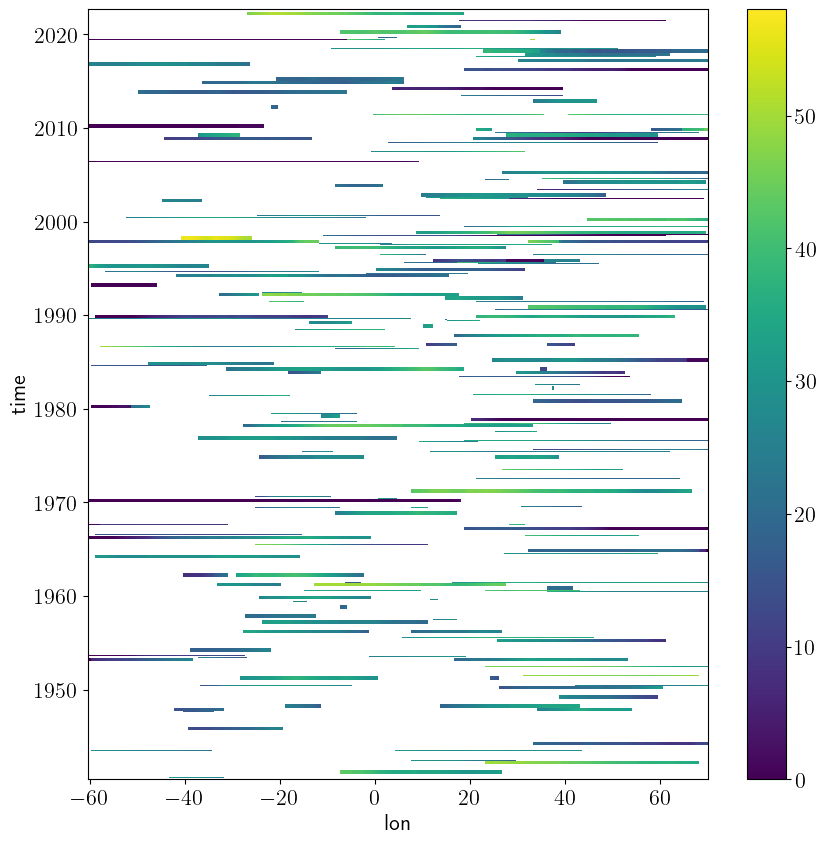

In [ ]:
da_vert_dists.plot(figsize=(10, 10))

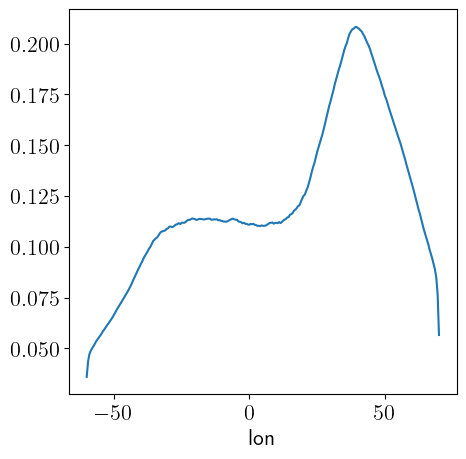

In [ ]:
(da_overlaps > 0).mean(dim='time').plot(figsize=(5, 5))

## Seasonal variability ?

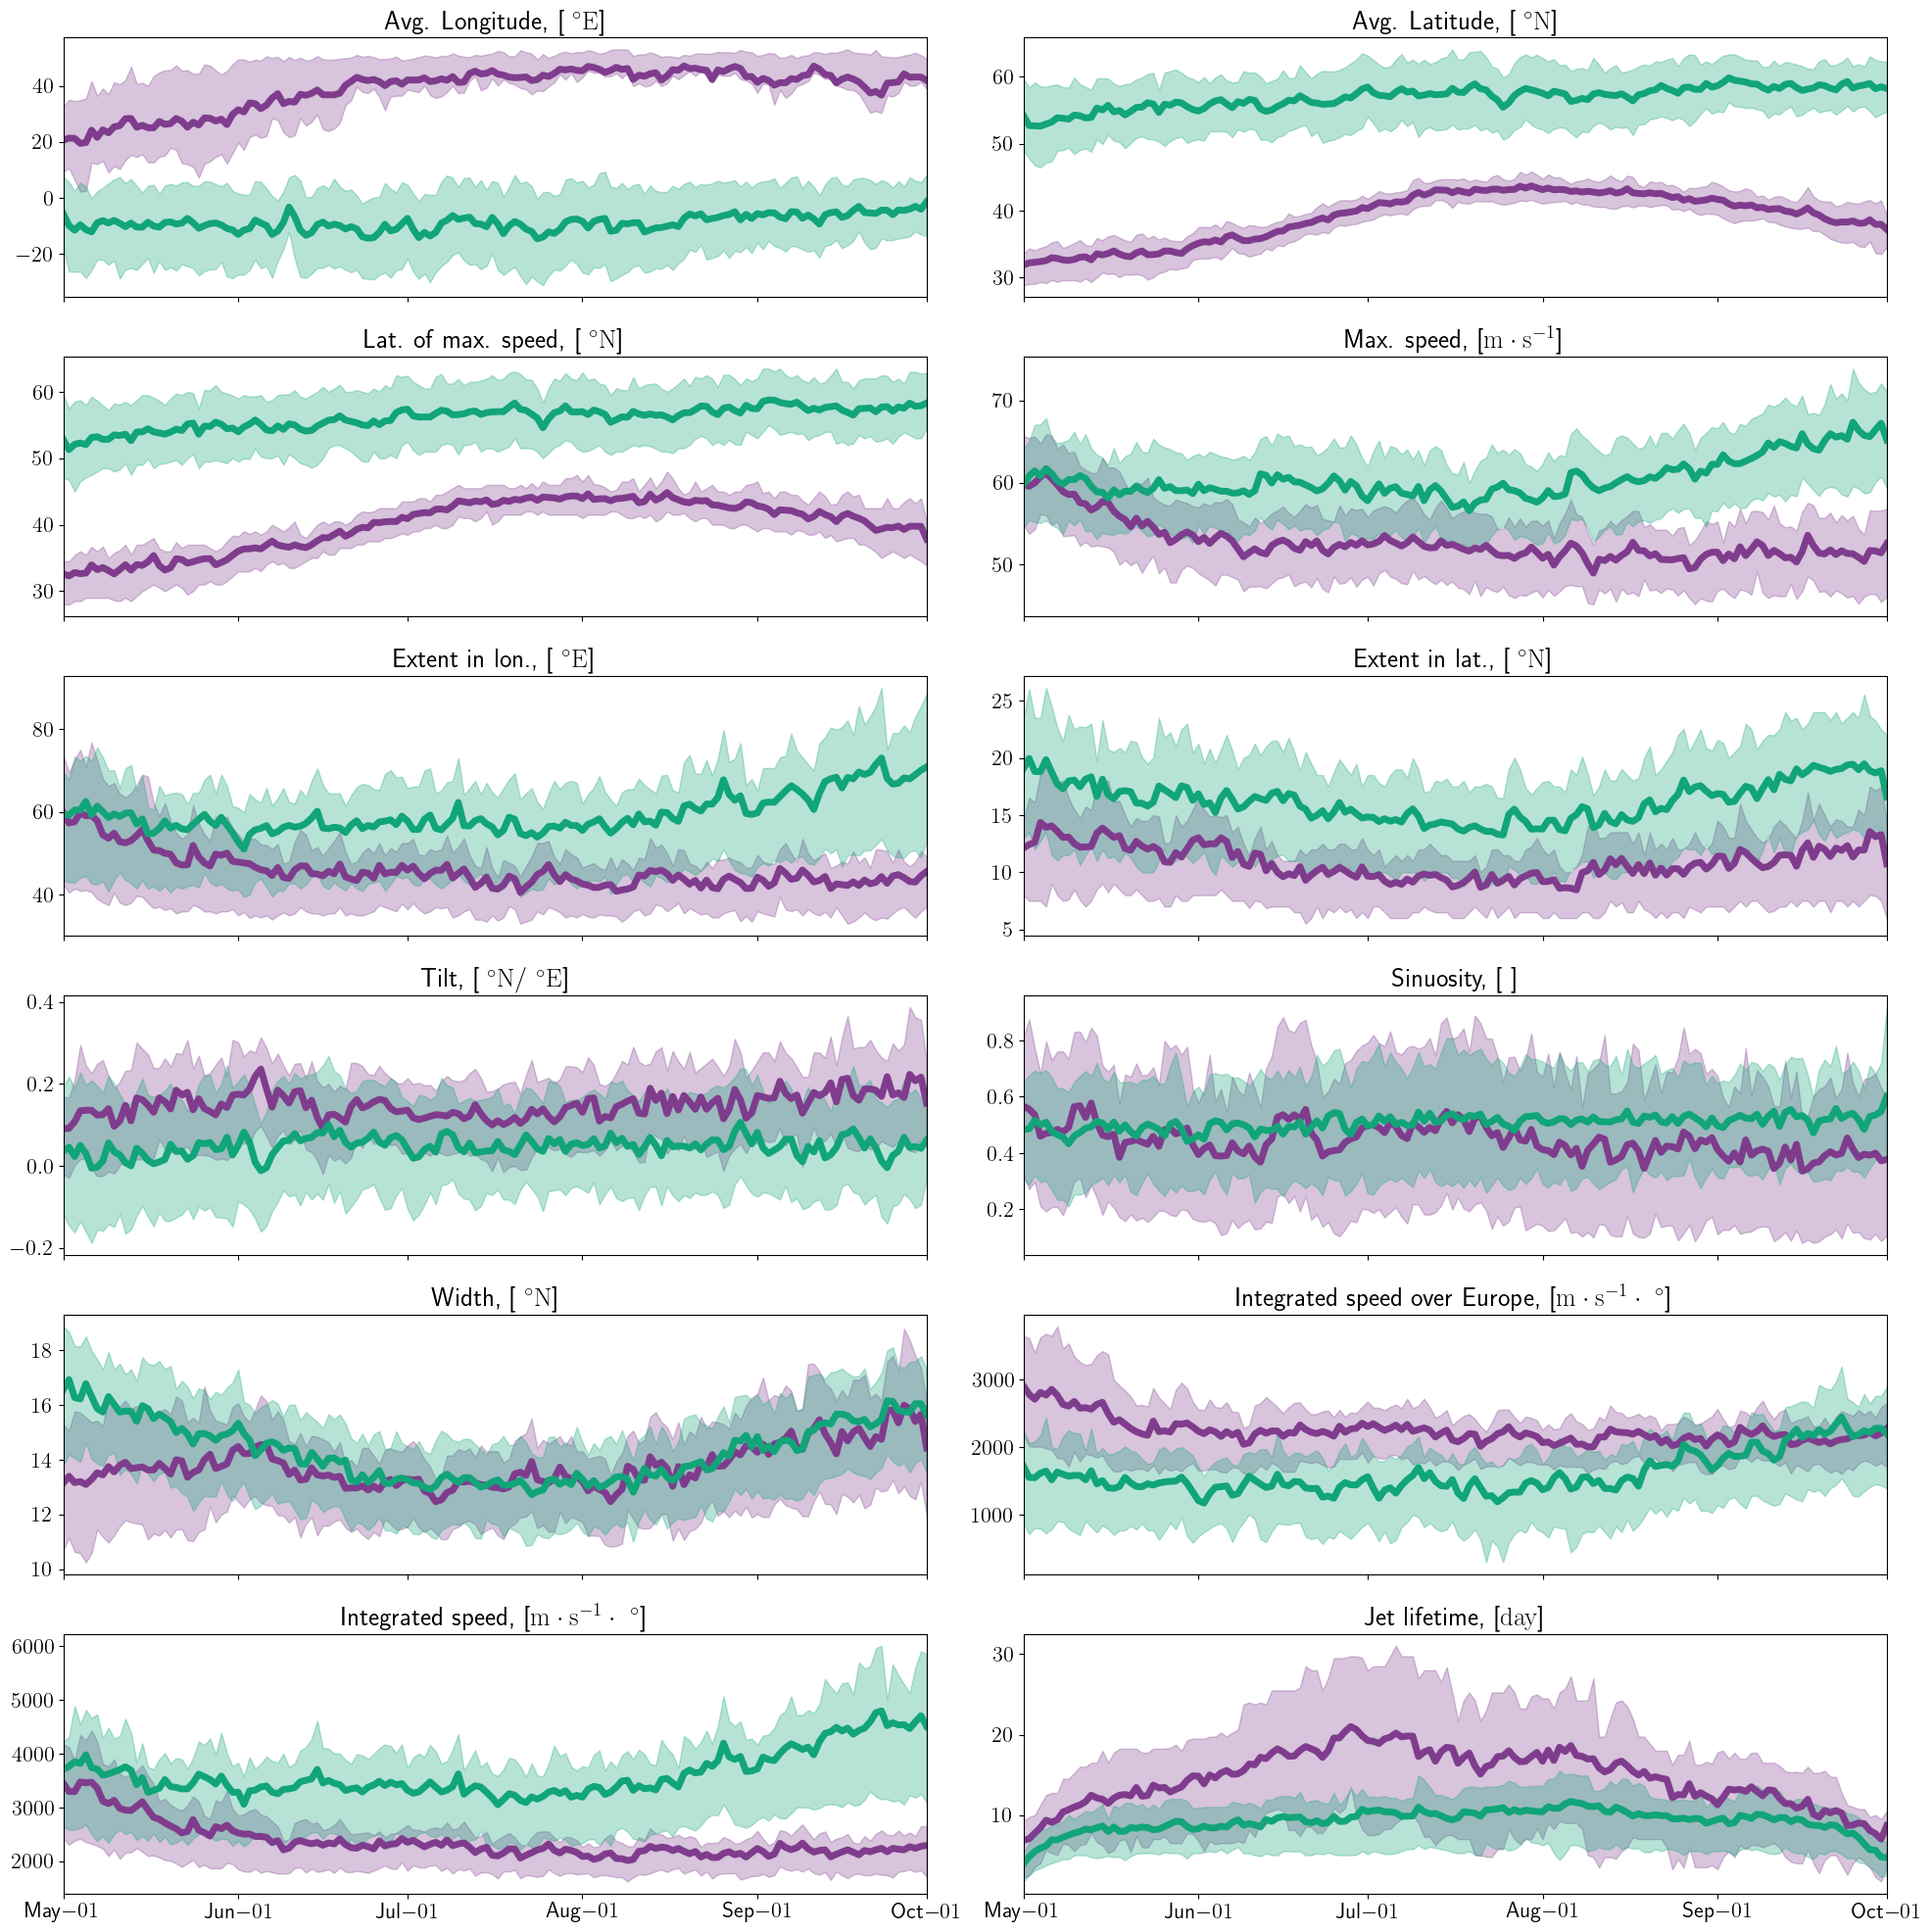

In [ ]:
from matplotlib.dates import DateFormatter
data_vars = [varname for varname in props_as_ds.data_vars if varname not in ['int_low', 'is_polar', 'Lon']]
fig, axes = plt.subplots(6, 2, figsize=(20, 20), tight_layout=True, sharex='all ')
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby('time.dayofyear')
    x = list(gb.groups.keys())
    x = DATERANGEPL_EXT[x]
    ys = gb.mean().values
    qs = gb.quantile(q=[0.25, 0.75]).values
    for i in range(2):
        ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=colormaps.bold(i), alpha=0.3)
        ax.plot(x, ys[:, i], lw=5, color=colormaps.bold(i))
    ax.set_title(f'{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]') 
    ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))
    ax.set_xlim(min(x), max(x))